<div align="right">
  Lukas Blecher
</div>
# Programing exercise 1: Single particle in a 1D potential

Due on Monday, 29.10.2018, 14.15h

### Total: 100 points

## Defining the problem

We want to calculate the eigenenergies and eigenfunction of a quantum particle in a on-dimensional potential, i.e. solve the eigenvalue problem

$$\left[\frac{1}{2} \partial_{x}^2 + V(x)\right] \phi(x) = E \phi(x)$$

by representing the wave function $\phi(x)$ on a discrete spatial grid.

In [1]:
# load standard libraries

import numpy as np   # standard numerics library
from ipywidgets import interactive # interactive
from scipy.optimize import curve_fit    # for fitting
import matplotlib.pyplot as plt   # for making plots
from scipy.sparse import diags    # for creating the hamiltionian
from scipy.sparse.linalg import eigsh #for exercise 4
%matplotlib inline

### Exercise 1 (25 points)

Solve the eigenproblem using numpy.linalg.eig().
Use a grid size of 20 length units and 401 gridpoints as a test case and plot the eigenfunctions.
Use an interactive function to look at the eigenfunctions systematically. The following example helps you with this.

Need to solve $$\hat H \phi (x) = E\phi(x)$$ with hamiltonian $\hat H=\frac{1}{2} \partial_{x}^2 + V(x)$, the eigenvalues $E$ and the eigenfunctions $\phi (x)$ $$\hat H=\left({\begin{array}{cc}
   V(x_1)+\frac{1}{\Delta x^2} & \frac{-1}{2\Delta x^2} &0& \cdots & &\\
   \frac{-1}{2\Delta x^2} & V(x_2)+\frac{1}{\Delta x^2} & \ddots & & & \\
   0 &\ddots  &\ddots &\  &&\\
   \vdots&&&&&\\
  \end{array} } \right)$$Our Potential is the harmonic oscilliator potential: $$V(x)=\frac12 mw^2x^2=\frac12 x^2,\quad m=w=1$$

In [2]:
def harmPot(x,**kwargs): #harmonic potential
    return x**2/2

#creates the hamiltonian with 'num' gridpoints from 'start' to 'end'
#the default potential is the haronic potential. Later for exercise 6 we need other potentials.
def hamilton(start,end,num,V=harmPot,toArray=True,**kwargs): 
    dx=abs(end-start)/num
    x=np.linspace(start,end,num)
    offsetOne=np.ones(num-1)*(-1/(2*dx**2))
    diagonals=[offsetOne,V(x,**kwargs)+np.ones(num)/dx**2,offsetOne]
    if toArray:
        return diags(diagonals,[-1,0,1]).toarray()
    else:
        return diags(diagonals,[-1,0,1])

#returns sorted eigenvectors and eigenvalues. For later there is the option to use the scipy.sparse.eigsh(...) function
#instead of the numpy.linalg.eig(...)
def eigvec(L,num,useSparseEigsh=False,k=None,V=harmPot,**kwargs):
    w,v=None,None
    if useSparseEigsh:
        if k==None: #set k to the maximum if it is not otherwise defined
            k=num-1
        w,v=eigsh(hamilton(-abs(L),abs(L),num,V,toArray=False,**kwargs),k=k,which='SM')
    else:
        w,v=np.linalg.eig(hamilton(-abs(L),abs(L),num,V,**kwargs))
    return v[:,np.argsort(w)],np.sort(w)

#retruns also the x linspace.
def xvandw(L,num,useSparseEigsh=False,V=harmPot,**kwargs):
    a,b=eigvec(L,num,useSparseEigsh,V,**kwargs)
    return np.linspace(-L,L,num),a,b


In [3]:
L,num=10,401
v,w=eigvec(L,num)
x=np.linspace(-L,L,num)

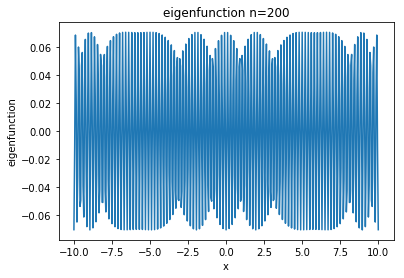

In [4]:
def f(k):
    plt.figure(2)
    plt.plot(x,v[:,k])
    plt.xlabel('x')
    plt.ylabel('eigenfunction')
    plt.title('eigenfunction n=%i'%k)
    plt.show()
interactive_plot= interactive(f,k=(0,num-1))
interactive_plot

### Exercise 2 (15 points)

Check the convergence of the numerical solutions with respect to grid size and spacing. Compare the eigenvalues and eigenfunction to analytical solutions. You may find the function scipy.special.hermite(...) useful.

In [5]:
from scipy.special import hermite
from scipy.misc import factorial
def eigenfunction(x,n):
    return hermite(n)(x)*np.exp(-x**2/2) #1/np.sqrt(2**n*factorial(n)*np.pi**.5)* normalize later
def eigenvalues(nMax):
    vth=[]
    for i in range(nMax):
        vth.append(i+.5)
    return np.array(vth)
def normalize(y):
    return y/np.linalg.norm(y)

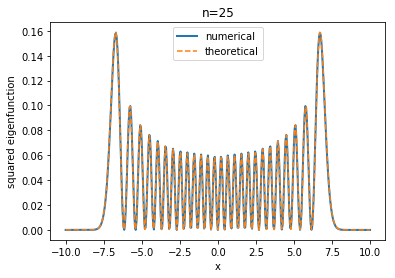

In [24]:
x,v,w=xvandw(10,401)
def f(k):
    plt.figure(2)
    plt.plot(x,normalize(v[:,k]**2),lw=2,label='numerical')
    plt.plot(x,normalize(eigenfunction(x,k)**2),'--',label='theoretical')
    plt.legend()
    plt.title('n=%i'%k)
    plt.xlabel('x')
    plt.ylabel('squared eigenfunction')
    plt.show()
interactive_plot= interactive(f,k=(0,50))
interactive_plot

the analytical and numerical solution are for small n the same function. for n>40 you start to see some difference between them. Another difference is the normalization which I redid for both of them so I could compare them. I plotted the square of the wave function because the numerical solution has sometimes the wrong sign.

Now calculate the error. Fist variate the spacing then the range
#### Spacing

Text(0.5, 1.0, 'maximal error as function of the number of gridpoints')

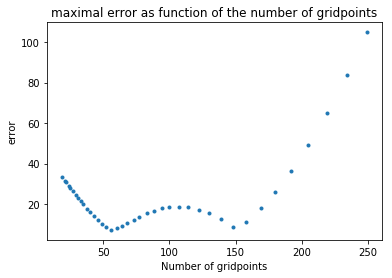

In [21]:
#first change the spacing with constant range=10
errSpace=[]
r=np.logspace(np.log(20)/np.log(10),np.log(250)/np.log(10),40,dtype=int) #logspace for 'importance sampling'
for i in r:
    v,w=eigvec(10,i)
    #identify maximal difference between numerical and theoretical solution
    errSpace.append(max(abs(abs(w)-np.linspace(0,i-1,i,dtype=int)-np.ones(i)*.5)))
plt.plot([*r],errSpace,'.')
plt.xlabel('Number of gridpoints')
plt.ylabel('error')
plt.title('maximal error as function of the number of gridpoints')

Text(0, 0.5, 'error')

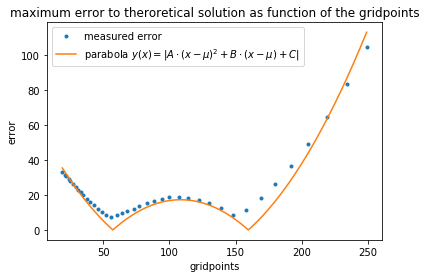

In [22]:
def abspar(x,a,u,c,d):
    return abs(a*(x+u)**2+c+d*(x+u))
plt.plot([*r],errSpace,'.',label='measured error')
p,o=curve_fit(abspar,[*r],errSpace,p0=[3.73568398e-03,6.57648092e+02,-5.6e2,-1.50720072e+03])
grid=np.linspace([*r][0],[*r][-1],1000)
plt.plot(grid,abspar(grid,*p),label='parabola $y(x)=|A\cdot (x-\mu)^2+B\cdot (x-\mu)+ C|$')
plt.legend()
plt.xlabel('gridpoints')
plt.title('maximum error to theroretical solution as function of the gridpoints')
plt.ylabel('error')

For some reason the error resembles a parabola. I fitted a parabola to point this out but I'm not sure if it is even correct. It was just an empirical observation.

Text(0.5, 1.0, 'error of the groundstate as function of the number of gridpoints')

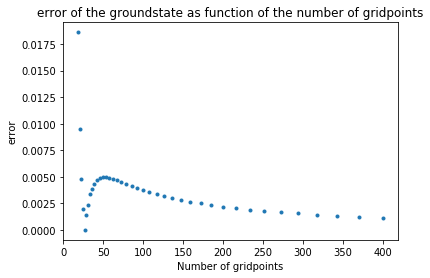

In [212]:
#first change the spacing with constant range=10
errSpace=[]
r=np.logspace(np.log(20)/np.log(10),np.log(401)/np.log(10),40,dtype=int) #range(20,400,5)
for i in r:
    v,w=eigvec(10,i)
    #identify groundstate error
    errSpace.append(abs(abs(w[0])-.5))
plt.plot([*r],errSpace,'.')
plt.xlabel('Number of gridpoints')
plt.ylabel('error')
plt.title('error of the groundstate as function of the number of gridpoints')

For the ground state the error does infact fall for more gridpoints.
#### Range

Text(0.5, 1.0, 'maximal error as function of the range')

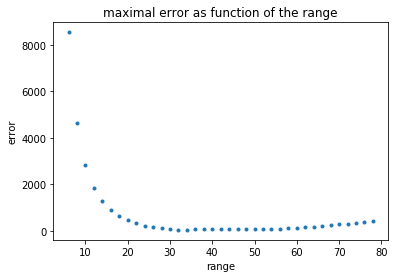

In [215]:
#now change the range with constant number of gridpoints=401
errRange=[]
r=range(6,80,2)
for i in r:
    x,v,w=xvandw(i/2,401)
    #identify maximal difference between numerical and theoretical solution
    errRange.append(max(abs(abs(w)-np.linspace(0,400,401,dtype=int)-np.ones(401)*.5)))
plt.plot(*[r],errRange,'.')
plt.xlabel('range')
plt.ylabel('error')
plt.title('maximal error as function of the range')

Intereting is that the error has at least one minimum in both cases when looking at the maximum of the error. I would have expect that it gets smaller with more accuracy, like it does for the groundstate

Text(0.5, 1.0, 'groundstate error as function of the range')

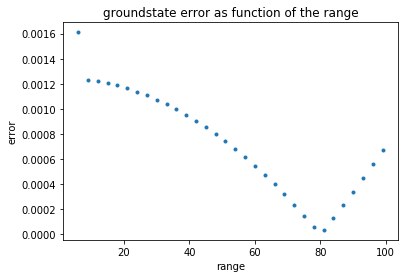

In [20]:
#first change the spacing with constant range=10
errRange=[]
r=range(6,100,3)
for i in r:
    v,w=eigvec(i/2,401)
    #identify groundstate error
    errRange.append(abs(abs(w[0])-.5))
plt.plot([*r],errRange,'.',label='error points')
plt.xlabel('range')
plt.ylabel('error')
plt.title('groundstate error as function of the range')

### Exercise 3 (15 points)

How does the runtime scale with the basis size (number of grid points)? (For example increase the number of gridpoints from 101 to 1601 in steps of 100) Interpret the result. How does it scale with the number of gridpoints? Using the "time" module you can measure the time it takes to do the diagonalization by doing something like:

In [6]:
import time
def parabola(x,a):
    return a*x**2

In [30]:
runtimes=[]
r=range(101,1701,100)
for i in r:
    ti = time.time()
    eigvec(10,i)
    tf = time.time()
    runtimes.append(tf-ti)

a=1.63e-06


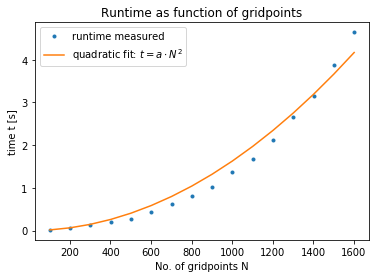

In [31]:
N=np.array([*r])
plt.plot(N,runtimes,'.',label='runtime measured')
plt.title('Runtime as function of gridpoints')
plt.xlabel('No. of gridpoints N')
plt.ylabel('time t [s]')
popt,pcov=curve_fit(parabola,N,runtimes,p0=[1.5e-6])
plt.plot(N,parabola(N,*popt),label='quadratic fit: $t=a\cdot N^2$')
plt.legend()
print('a=%.2e'%popt[0])

The quadratic behavior can be seen clearly in this plot. 

### Exercise 4 (20 points)

Calculate only the lowest (e.g. 20) eigenvalues, using sparse matrices. Compare the runtime to your previous implementation. For diagonalising a sparse symmetric matrix, you can use scipy.sparse.linalg.eigsh(...)

In [32]:
#imported scipy.sparse.linalg.eigsh() in the beginning
#Now redo Exercise 3 only this time set useSparseEigsh=True
runtimes=[]
r=range(101,1701,100)
for i in r:
    ti = time.time()
    eigvec(10,i,True)
    tf = time.time()
    runtimes.append(tf-ti)

Text(0, 0.5, 'time t [s]')

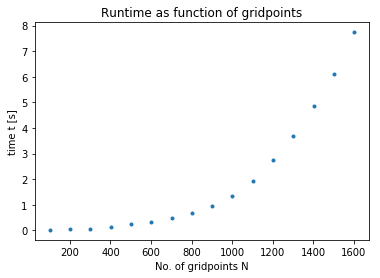

In [33]:
N=np.array([*r])
plt.plot(N,runtimes,'.',label='runtime measured')
plt.title('Runtime as function of gridpoints')
plt.xlabel('No. of gridpoints N')
plt.ylabel('time t [s]')

the absolute time of the calculation is about twice as long as the calculation time using numpy.linalg.eig().
I did't let the algorithm compute only 20 eigenvectors here but all it could handle ($N-1$) so I could compare it to numpy.linalg.eig()
But because it is in the text I'll do also a measurement of only the first 20 eigenvectors:

In [34]:
#Now k=20
runtimes=[]
r=range(101,1601,100)
for i in r:
    ti = time.time()
    eigvec(10,i,True,k=20)
    tf = time.time()
    runtimes.append(tf-ti)

Text(0, 0.5, 'time t [s]')

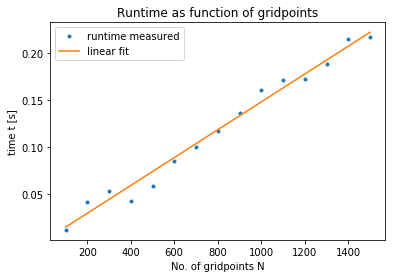

In [35]:
N=np.array([*r])
popt,pcov=curve_fit(lambda x,a:a*x,N,runtimes)
plt.plot(N,runtimes,'.',label='runtime measured')
plt.plot(N,N*popt[0],label='linear fit')
plt.legend()
plt.title('Runtime as function of gridpoints')
plt.xlabel('No. of gridpoints N')
plt.ylabel('time t [s]')

For only 20 eigenvectors it takes very little time even for many gridpoints. It looks like a linear function but probably is only t

### Exercise 5 (15 points)

Implement the time evolution of superpositions of eigenstates as initial states. Hint: Read about broadcasting rules in python. Animate the time evolution using the framework sketched below:

In [7]:
class linComb:
    #initialise the linear combination
    def __init__(self,scalars,vectors,eigenvalues):
        #check for unregularities
        if len(scalars) != len(vectors) or len(scalars)!=len(eigenvalues):
            raise ValueError('scalars, vectors and eigenvalues have not the same length')
        if len(scalars)<1:
            raise ValueError('empty scalars and vectors')
        #save data
        self.state=np.zeros(len(vectors[0]))
        self.eigenvalues=eigenvalues
        self.scalars=scalars
        self.vectors=vectors
        #construct wave function at time t=0
        for i in range(len(scalars)):
            self.state+=scalars[i]*vectors[i]
            
    # gives back the wave function at the time t        
    def timeEvolution(self,t):
        stateT=np.zeros(len(self.state),dtype=complex) #initialize new state
        for i in range(len(self.scalars)):
            stateT+=self.scalars[i]*(np.exp(-1j*self.eigenvalues[i]*t)*self.vectors[i])
        #return real part and imaginary part
        return np.real(stateT),np.imag(stateT)

Text(0.5, 1.0, 'initial state')

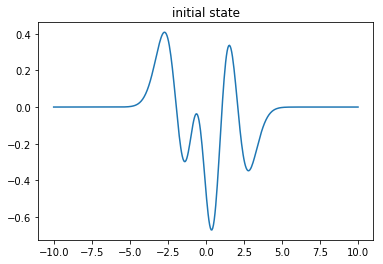

In [20]:
#for this exercise: L/2=10, N=401
x,v,w=xvandw(10,401)
#initial state
initial=linComb([1,3,-2],[v[:,2],v[:,5],v[:,0]],[w[2],w[5],w[0]])
plt.plot(x,initial.state)
plt.title('initial state')

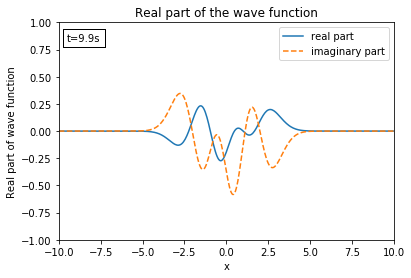

In [28]:
from matplotlib import animation
from IPython.display import HTML

fig, ax = plt.subplots()
# add axis specifications
line, = ax.plot([],[],label='real part')
linei,=ax.plot([],[],'--',label='imaginary part')

plt.ylim(-1,1)
plt.xlim(-10,10)
plt.legend()
plt.xlabel('x')
plt.ylabel('Real part of wave function')
plt.title('Real part of the wave function')
def animate(t):
    # assign current wave function to y
    # x is gloabaly defined
    real,imag=initial.timeEvolution(t)
    line.set_data(x,real)
    linei.set_data(x,imag)
    #plt.legend()
    plt.text(-9.5,.9,'t=%.1fs'%t,ha='left',va='top',bbox=dict(facecolor='white', alpha=1))
    return (line,)

anim = animation.FuncAnimation(fig, animate,
                               frames=np.arange(0,10,.1), # t-values
                               interval=50, # wait time before displaying new frame in ms
                               blit=True)

HTML(anim.to_jshtml())

### Exercise 6 (10 points)

Calculate eigenvalues and eigenfunction for other potentials. Try out adding a quartic term:
$$
V(x)=\frac{1}{2}x^2 + \lambda x^4
$$
Try a double well:
$$
V(x)=-\frac{1}{2}x^2 + \lambda x^4
$$
What happens? Interpret your results.

In [8]:
def quatric(x,**kwargs):
    l=0
    for i,j in kwargs.items():
        if i=='l': #not the best solution but it works. Would need other structuring from the beginning
            l=j
    return x**2/2+l*x**4
def doubleWell(x,**kwargs):
    l=0
    for i,j in kwargs.items():
        if i=='l':
            l=j
    return -x**2/2+l*x**4

In [9]:
def eigenfunctionPot(V):
    
    def f(n,l):
        x=np.linspace(-10,10,401)
        v,w=eigvec(10,401,V=V,useSparseEigsh=True,l=l,k=20)
    
        plt.figure(2)
        plt.plot(x,normalize(v[:,n]**2))
        plt.title('%s, n=%i, $\lambda$=%.1e'%(V.__name__,n,l))
        plt.xlabel('x')
        plt.ylabel('squared eigenfunction')
        plt.show()
    #interactive_plot= interactive(f,k=(0,len(w)-1))
    return interactive(f,n=(0,19),l=(0,.03,.001))

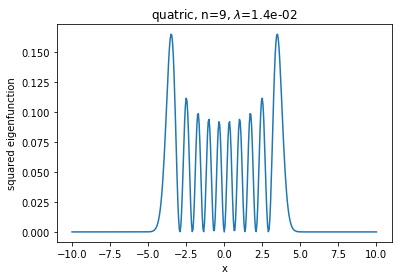

In [10]:
eigenfunctionPot(quatric)

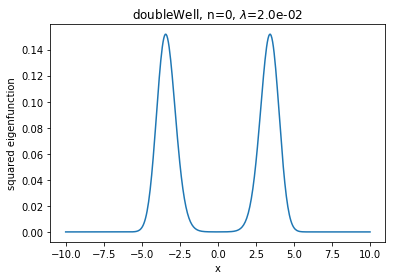

In [11]:
eigenfunctionPot(doubleWell)


the eigenfunctions are for small $\lambda$'s similar to the harmonic oscillator solutions but we have clearly some kind of tunneling/reflection as soon as the parameter $\lambda$ is high enough to make a difference in the potential. For the double well potential with e.g. $\lambda = 0.02$ and $n=0$ we have two seperate peaks in each of the potential minimas.

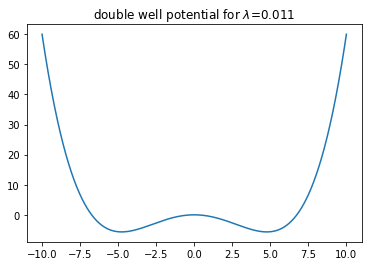

In [12]:
#effect of lambda to potential
def f(l):
    x=np.linspace(-10,10,1000)
    plt.plot(x,doubleWell(x,l=l))
    plt.title('double well potential for $\lambda$=%.3f'%l)
    plt.show()

interactive_plot= interactive(f,l=(0,.03,.001))
interactive_plot